In [70]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy
import gc
from PIL import Image


root = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))

sys.path.append(os.path.join(root,'imStat','code'))
import utils
import model_src
import other_model_code
from model_src import gabor_feature_extractor
from utils import torch_utils
from model_src import texture_statistics

sys.path.append(os.path.join(root,'toolboxes','texture-synthesis-portilla-simoncelli'))
# import steerable_pyramid

import pyrtools as pt
# this is a package described at https://pyrtools.readthedocs.io/en/latest/

In [3]:
import torch
# device = torch.device('cpu:0')
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce RTX 2080 Ti

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


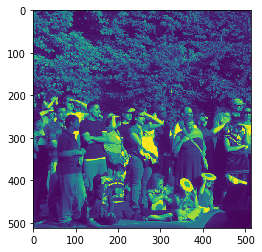

In [29]:
image = Image.open('example-im-512x512.png')
image = np.reshape(image.getdata(),[512,512])

plt.figure();
plt.pcolormesh(image)
plt.axis('square')
plt.gca().invert_yaxis()

In [269]:

n_ori=4;
n_sf=4;
padding_mode='circular'

feature_extractor = steerable_pyramid_extractor(pyr_height=n_sf, n_ori = n_ori)
features_complex, features_real, features_resid = feature_extractor(np.expand_dims(np.expand_dims(image, axis=0), axis=0), to_torch=False, device=device)

print(features_complex[0].shape)
print(features_complex[-1].shape)

time elapsed: 0.21225 s
(1, 4, 64, 64)
(1, 4, 512, 512)


In [49]:
features_complex[0].shape

(1, 4, 64, 64)

In [760]:
# % this function just pulls out features from a desired feature map and
# % reshapes them back into square image format (ch is [npix x npix])
# % here it's grabbing the last band in pyramid (lowest SF)
# % note this is REAL part not abs
lowpass_resid = features_resid[0][0,0,:,:]

# % when this function is called with 0 height (ht) all it does is return a
# % low pass and a high pass filtered version of the input image. [high then low]
feature_extractor_dummy = steerable_pyramid_extractor(pyr_height=0, n_ori=1)
features_complex_dummy, features_real_dummy, features_resid_dummy = feature_extractor_dummy(np.expand_dims(np.expand_dims(lowpass_resid, axis=0), axis=0), to_torch=False, device=device)

# % then "im" is the low-frequency version of the feature map
lowpass_recon = features_resid_dummy[0][0,0,:,:]
# [Nly Nlx] = size(ch);

time elapsed: 0.00343 s


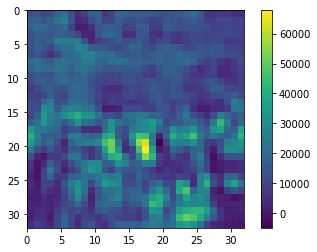

In [61]:
plt.figure();
plt.pcolormesh(lowpass_resid)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()
print()

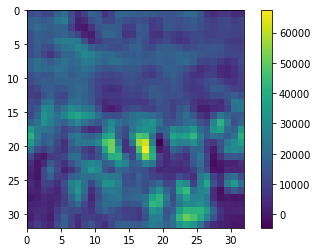

In [62]:
plt.figure();
plt.pcolormesh(lowpass_recon)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()


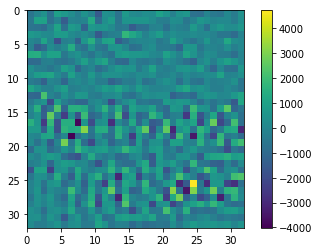

In [63]:
plt.figure();
plt.pcolormesh(lowpass_recon-lowpass_resid)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()


In [761]:
npix = 32
xvals, yvals = np.meshgrid(np.linspace(-1,1,npix), np.linspace(-1,1,npix));
rvals = np.sqrt(xvals**2 + yvals**2);
gauss = np.exp(-rvals/0.5);

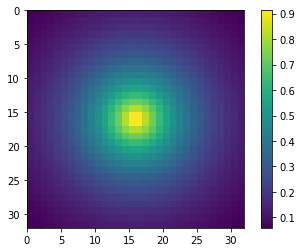

In [66]:
plt.figure();
plt.pcolormesh(gauss);
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [762]:
spatial_weights = gauss
ind = [15,22,14,21]
ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
acor = weighted_auto_corr_2d(np.expand_dims(np.expand_dims(lowpass_recon, axis=0), axis=0), \
                                                spatial_weights, patch_bbox=ind, output_pix=5, \
                                               subtract_patch_mean=True, enforce_size=True, device=None)

In [763]:
acor

tensor([[[[-3566656.2500,  9842908.0000, 11825795.0000,  1607324.0000,
           -4779803.0000],
          [-6164116.0000, 14284130.0000, 22741334.0000,  5014411.0000,
           -8861655.0000],
          [-7407718.0000, 14885898.0000, 33389956.0000, 14885898.0000,
           -7407718.0000],
          [-8861655.0000,  5014411.0000, 22741334.0000, 14284130.0000,
           -6164116.0000],
          [-4779803.0000,  1607324.0000, 11825795.0000,  9842908.0000,
           -3566656.2500]]]])

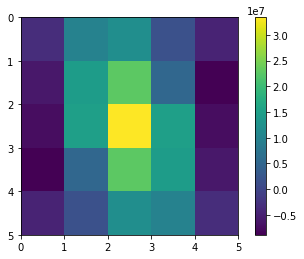

In [169]:
plt.figure();
plt.pcolormesh(acor[0,0,:,:])
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [192]:
np.unique(acor)

array([-8861655. , -7407718. , -6164116. , -4779803. , -3566656.2,
        1607324. ,  5014411. ,  9842908. , 11825795. , 14284130. ,
       14885898. , 22741334. , 33389956. ], dtype=float32)

In [764]:

# Taking just the "unique" values in this matrix, so we don't end up w redundant model features. Get the upper triangle and the first half of the diagonal.
height = acor.shape[2]
inds1, inds2 = np.triu_indices(height,1)
unvals = acor[:,:,inds1, inds2]
unvals2 = acor[:,:,np.arange(0,int(np.ceil(height/2))), np.arange(0,int(np.ceil(height/2)))]
unvals = torch.cat([unvals, unvals2], axis=2)
assert(torch.numel(unvals)==int((height**2+1)/2))
assert(torch.numel(torch.unique(unvals))==torch.numel(torch.unique(acor)))

print(unvals)

tensor([[[ 9842908.0000, 11825795.0000,  1607324.0000, -4779803.0000,
          22741334.0000,  5014411.0000, -8861655.0000, 14885898.0000,
          -7407718.0000, -6164116.0000, -3566656.2500, 14284130.0000,
          33389956.0000]]])


In [765]:
spatial_weights = gauss
wmean, wvar, wskew, wkurt = get_weighted_pixel_features(np.expand_dims(np.expand_dims(lowpass_recon, axis=0), axis=0), \
                                                        spatial_weights, device=None)

In [767]:
spatial_weights.shape

(32, 32)

In [249]:
[wkurt, wskew]


[tensor([[5.8525]]), tensor([[1.3495]])]

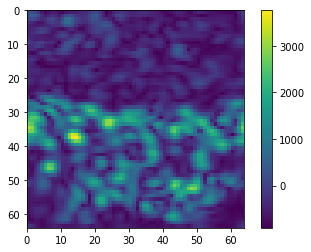

In [323]:
sc=0
ori=0
ch = features_complex[sc][0,ori,:,:]
ch = ch - np.mean(ch)
plt.figure()
plt.pcolormesh(ch);
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [324]:
sc_reverse = n_sf-1 - sc
sc_reverse
[sc, sc_reverse]

[0, 3]

In [331]:
npix = pyr.pyr_size[(sc_reverse,0)][0]
if sc==0:
    smaller_size = pyr.pyr_size['residual_lowpass'][0]
else:
    smaller_size = pyr.pyr_size[(sc_reverse+1,0)][0]
[npix, smaller_size]

[64, 32]

In [332]:

xvals, yvals = np.meshgrid(np.linspace(-1,1,npix), np.linspace(-1,1,npix));
rvals = np.sqrt(xvals**2 + yvals**2);
gauss = np.exp(-rvals/0.5);

spatial_weights = gauss
ind = [30,45,28,43]
ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
acor = weighted_auto_corr_2d(np.expand_dims(np.expand_dims(ch, axis=0), axis=0), \
                                                spatial_weights, patch_bbox=ind, output_pix=7, \
                                               subtract_patch_mean=True, enforce_size=True, device=None)

In [333]:
acor

tensor([[[[ 1.4045e+03,  1.1497e+04,  1.4363e+04,  6.6669e+03, -4.6323e+00,
           -4.4469e+03, -4.3603e+03],
          [ 1.0419e+04,  2.4004e+04,  3.0249e+04,  2.5121e+04,  1.3730e+04,
            2.7887e+03, -2.9265e+03],
          [ 1.4745e+04,  3.3858e+04,  5.3108e+04,  6.0087e+04,  4.1710e+04,
            1.8249e+04,  2.2544e+03],
          [ 9.8600e+03,  3.2841e+04,  6.3587e+04,  8.3420e+04,  6.3587e+04,
            3.2841e+04,  9.8600e+03],
          [ 2.2544e+03,  1.8249e+04,  4.1710e+04,  6.0087e+04,  5.3108e+04,
            3.3858e+04,  1.4745e+04],
          [-2.9265e+03,  2.7887e+03,  1.3730e+04,  2.5121e+04,  3.0249e+04,
            2.4004e+04,  1.0419e+04],
          [-4.3603e+03, -4.4469e+03, -4.6318e+00,  6.6669e+03,  1.4363e+04,
            1.1497e+04,  1.4045e+03]]]])

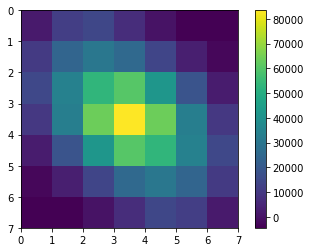

In [334]:
plt.figure()
plt.pcolormesh(acor[0,0,:,:]);
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [404]:
full_image = feature_extractor.reconstruct()

In [703]:
pyr = pt.pyramids.SteerablePyramidFreq(image, is_complex=False, height = feature_extractor.pyr_height, order = feature_extractor.n_ori-1)
full_image = pyr.recon_pyr()

In [725]:
pyr_adj = copy.deepcopy(pyr)
# for kk, key in enumerate(pyr.pyr_size.keys()):
#     if key[0]==sc:       
#         pyr_adj.pyr_coeffs[key] = pyr_adj.pyr_coeffs[key] - np.mean(pyr_adj.pyr_coeffs[key])
bandpass_image = pyr_adj.recon_pyr(levels=sc_reverse, bands='all', twidth=1)
bandpass_image = shrink(bandpass_image, factor=8)*8**2



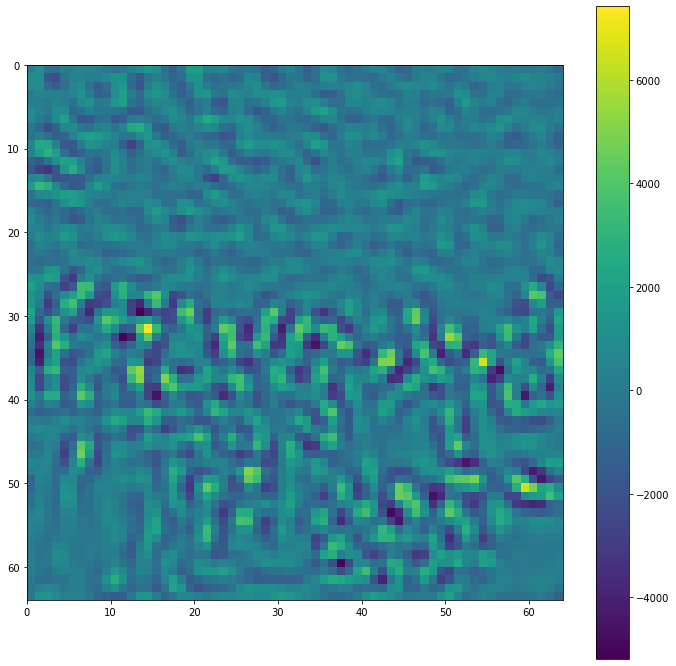

In [726]:
plt.figure(figsize=(12,12));
plt.pcolormesh(bandpass_image)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [522]:
bandpass_image[9,9]

420.8075402598855

In [521]:
lowpass_expanded[9,9]/4

6131.709254646928

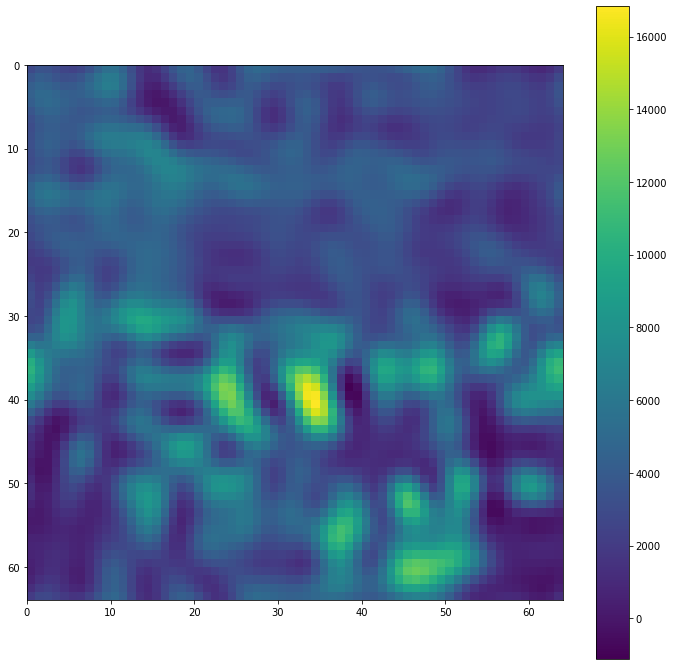

In [889]:
# Expanded version of lowpass reconstruction

plt.figure(figsize=(12,12));
lowpass_expanded = expand(lowpass_recon, factor=2)/2**2
plt.pcolormesh(lowpass_expanded)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

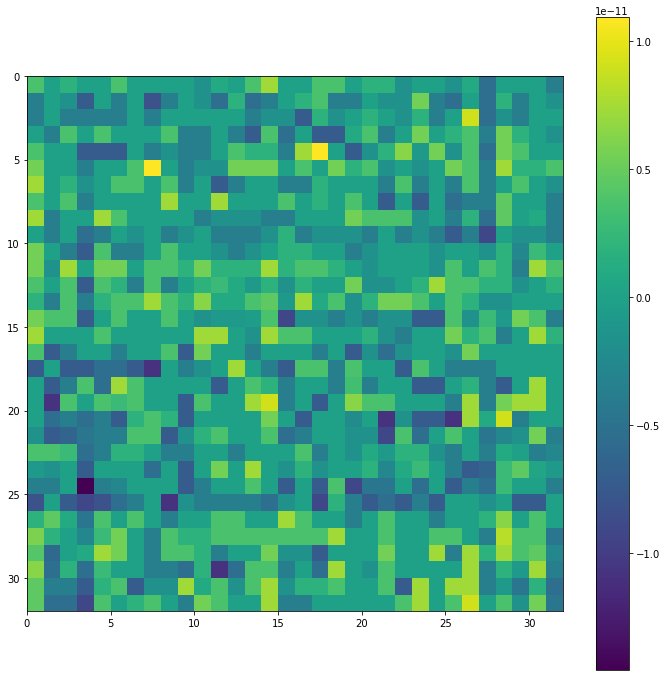

In [888]:
# Make sure that reversing the expanding gives back about same thing (no weird artifacts)
plt.figure(figsize=(12,12));
expanded = expand(lowpass_recon, factor=2)
shrunk = shrink(expanded, factor=2)
plt.pcolormesh(lowpass_recon - shrunk)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()


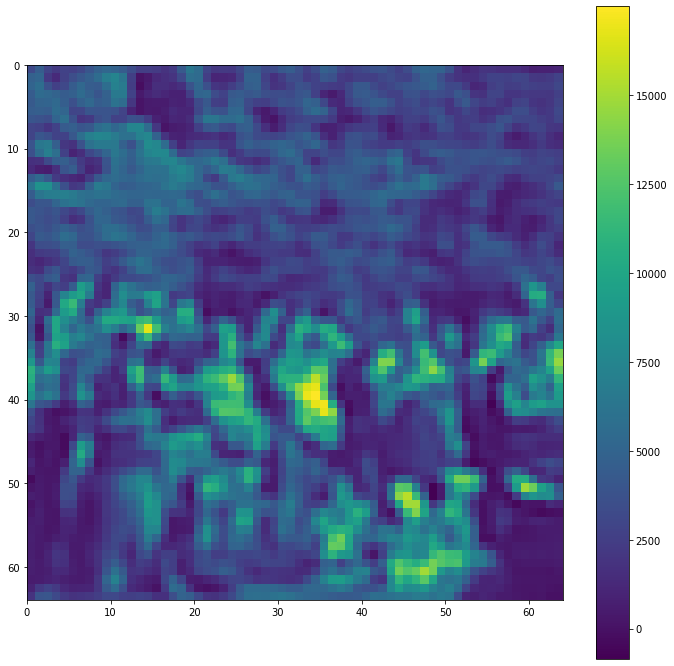

In [890]:
# Get the full summed lowpass representation
lowpass_summed = lowpass_expanded + bandpass_image

plt.figure(figsize=(12,12));
plt.pcolormesh(lowpass_summed)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [891]:
lowpass_summed[40,40]

726.9233171504522

In [942]:
npix = np.shape(lowpass_summed)[0]

def quick_gaussian(npix):
    xvals, yvals = np.meshgrid(np.linspace(-1,1,npix), np.linspace(-1,1,npix));
    rvals = np.sqrt(xvals**2 + yvals**2);
    gauss = np.exp(-rvals/0.5);
    return gauss

In [943]:
npix = np.shape(lowpass_summed)[0]
gauss = quick_gaussian(npix)

spatial_weights = gauss
ind = [30,45,28,43]
ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
acor = weighted_auto_corr_2d(np.expand_dims(np.expand_dims(lowpass_summed, axis=0), axis=0), \
                                                spatial_weights, patch_bbox=ind, output_pix=7, \
                                               subtract_patch_mean=True, enforce_size=True, device=None)

In [944]:
acor

tensor([[[[ 323371.6250,  720956.0000, 1027986.0000, 1114252.7500,  875465.7500,
            375377.0000, -296509.9062],
          [ 363607.3125,  767381.0000, 1243893.2500, 1528748.8750, 1112584.8750,
            313352.0000, -422486.6250],
          [ 176001.0000,  731780.5000, 1633567.1250, 2224725.2500, 1489591.3750,
            333494.6250, -392392.8750],
          [-166983.0000,  517725.4062, 1811850.2500, 2683015.5000, 1811850.2500,
            517725.4062, -166983.0000],
          [-392392.8750,  333494.6250, 1489591.3750, 2224725.2500, 1633567.1250,
            731780.5000,  176000.9844],
          [-422486.6250,  313352.0000, 1112584.7500, 1528748.8750, 1243893.1250,
            767381.0000,  363607.3125],
          [-296509.8750,  375377.0000,  875465.7500, 1114252.7500, 1027986.0000,
            720956.0000,  323371.6562]]]])

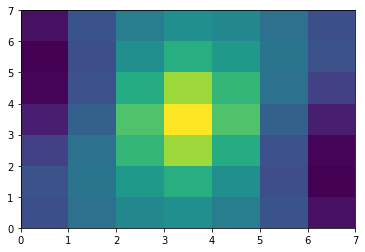

In [732]:
plt.figure;plt.pcolormesh(acor[0,0,:,:])

In [733]:
torch.unique(acor)

tensor([-422552.2812, -392427.1250, -296616.2188, -166991.0781,  176019.4844,
         313362.0000,  323464.0312,  333523.4688,  363658.0938,  375370.3438,
         517773.5625,  720945.6250,  731808.5000,  767389.2500,  875564.8750,
        1027888.8750, 1112643.7500, 1114257.2500, 1243837.5000, 1489619.3750,
        1528736.2500, 1633543.3750, 1811852.5000, 2224693.2500, 2682963.5000])

In [776]:

# Taking just the "unique" values in this matrix, so we don't end up w redundant model features. Get the upper triangle and the first half of the diagonal.
height = acor.shape[2]
inds1, inds2 = np.triu_indices(height,1)
unvals = acor[:,:,inds1, inds2]
unvals2 = acor[:,:,np.arange(0,int(np.ceil(height/2))), np.arange(0,int(np.ceil(height/2)))]
unvals = torch.cat([unvals, unvals2], axis=2)
assert(torch.numel(unvals)==int((height**2+1)/2))
assert(torch.numel(torch.unique(unvals))==torch.numel(torch.unique(acor)))

print(unvals)

tensor([[[ 720945.6250, 1027888.8750, 1114257.2500,  875564.8750,  375370.3438,
          -296616.2188, 1243837.5000, 1528736.2500, 1112643.7500,  313362.0000,
          -422552.2812, 2224693.2500, 1489619.3750,  333523.4688, -392427.1250,
          1811852.5000,  517773.5625, -166991.0781,  731808.5000,  176019.4844,
           363658.0938,  323464.0312,  767389.2500, 1633543.3750, 2682963.5000]]])


In [777]:
spatial_weights = gauss
wmean, wvar, wskew, wkurt = get_weighted_pixel_features(np.expand_dims(np.expand_dims(lowpass_summed, axis=0), axis=0), \
                                                        spatial_weights, device=None)

In [778]:
print([wskew, wkurt])

[tensor([[1.2617]]), tensor([[4.6411]])]


In [750]:
n_channels

1

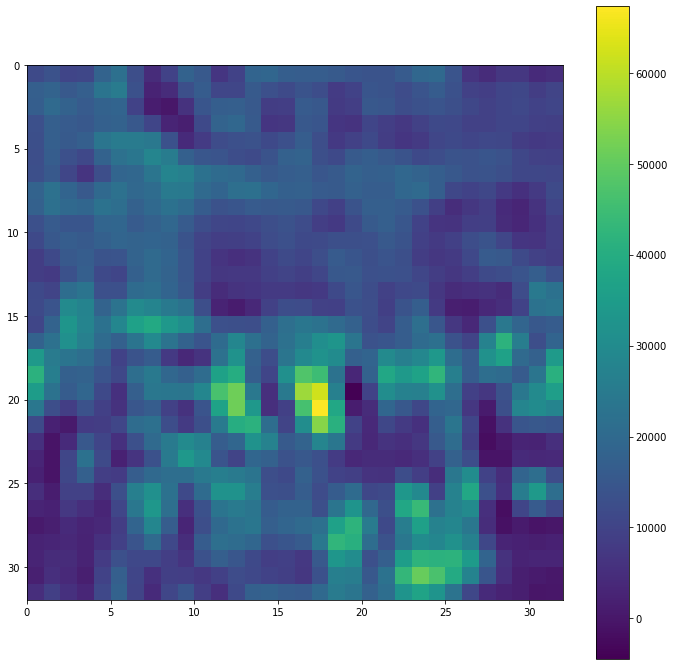

In [640]:
plt.figure(figsize=(12,12));
expanded = expand(lowpass_recon, factor=2)
shrunk = shrink(expanded, factor=2)
plt.pcolormesh(shrunk)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()



In [684]:
import scipy.fft

scipy.fft.fft2

<uarray multimethod 'fft2'>

In [780]:

# def get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=20, include_autocorrs=True, include_crosscorrs=True, autocorr_output_pix=7, n_prf_sd_out=2, aperture=1.0, device=None):

"""
Compute all higher-order features (cross-spatial and cross-feature correlations) for a batch of images.
Input the functions that define first level feature maps (simple and complex cells), and prf parameters.
Returns arrays of each higher order feature.    
"""

if device is None:
    device = torch.device('cpu:0')    

# n_trials = np.shape(images)[0]
n_trials = 1

assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

n_features_simple, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_simple, images[0:sample_batch_size], device)
n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)

n_sf = len(fmaps_rez)
n_ori = int(n_features_complex/n_sf)
n_phases = 2

# all pairs of different orientation channels.
ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
n_ori_pairs = np.shape(ori_pairs)[0]

if include_autocorrs:
    complex_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, autocorr_output_pix**2], device=device)
    simple_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, n_phases, autocorr_output_pix**2], device=device)
else:
    complex_feature_autocorrs = None
    simple_feature_autocorrs = None

if include_crosscorrs:
    complex_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device)
    simple_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_phases, n_ori_pairs], device=device)
    complex_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_ori, n_ori], device=device)
    simple_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_phases, n_ori, n_ori], device=device) # only done for pairs of neighboring SF.
else:
    complex_within_scale_crosscorrs = None
    simple_within_scale_crosscorrs = None
    complex_across_scale_crosscorrs = None
    simple_across_scale_crosscorrs = None

if include_autocorrs or include_crosscorrs:

    x,y,sigma = prf_params

    bb=-1
    for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
        bb=bb+1

        fmaps_complex = _fmaps_fn_complex(torch_utils._to_torch(images[batch_inds],device=device))   
        fmaps_simple =  _fmaps_fn_simple(torch_utils._to_torch(images[batch_inds],device=device))

        # First looping over frequency (scales)
        for ff in range(n_sf):

            # Scale specific things - get the prf at this resolution of interest
            n_pix = fmaps_rez[ff]
            g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
            spatial_weights = g[2][0]

            patch_bbox_rect = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=False)
            # for autocorrelation, forcing the input region to be square
            patch_bbox_square = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True)

            # Loop over orientation channels
            xx=-1
            for oo1 in range(n_ori):       


                # Simple cell responses - loop over two phases per orient.
                for pp in range(n_phases):
                    filter_ind = n_phases*oo1+pp  # orients and phases are both listed in the same dimension of filters matrix               
                    simple1 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                    # Simple cell autocorrelations.
                    if include_autocorrs:
                        auto_corr = weighted_auto_corr_2d(simple1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)
                        simple_feature_autocorrs[batch_inds,ff,oo1,pp,:] = torch.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                # Complex cell responses
                complex1 = fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])

                # Complex cell autocorrelation (correlation w spatially shifted versions of itself)
                if include_autocorrs:
                    auto_corr = weighted_auto_corr_2d(complex1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)       
                    complex_feature_autocorrs[batch_inds,ff,oo1,:] = torch.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                if include_crosscorrs:
                    # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
                    for oo2 in np.arange(oo1+1, n_ori):            
                        xx = xx+1 
                        assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                        complex2 = fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])      

                        # Complex cell within-scale cross correlations
                        cross_corr = weighted_cross_corr_2d(complex1, complex2, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)

                        complex_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                        # Simple cell within-scale cross correlations
                        for pp in range(n_phases):
                            filter_ind = n_phases*oo2+pp
                            simple2 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                            cross_corr = weighted_cross_corr_2d(simple1, simple2, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                            simple_within_scale_crosscorrs[batch_inds,ff,pp,xx] = torch.squeeze(cross_corr);

                    # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
                    # Only for neighboring scales, so the first level doesn't get one
                    if ff>0:

                        for oo2 in range(n_ori):

                            # Complex cell response for neighboring scale
                            complex2_neighborscale = fmaps_complex[ff-1][:,oo2,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                            # Resize so that it can be compared w current scale
                            complex2_neighborscale = torch.nn.functional.interpolate(complex2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                            cross_corr = weighted_cross_corr_2d(complex1, complex2_neighborscale, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                            complex_across_scale_crosscorrs[batch_inds,ff-1, oo1, oo2] = torch.squeeze(cross_corr)

                            for pp in range(n_phases):
                                filter_ind = n_phases*oo2+pp
                                # Simple cell response for neighboring scale
                                simple2_neighborscale = fmaps_simple[ff-1][:,filter_ind,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                                simple2_neighborscale = torch.nn.functional.interpolate(simple2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                                cross_corr = weighted_cross_corr_2d(simple1, simple2_neighborscale, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                                simple_across_scale_crosscorrs[batch_inds,ff-1, pp, oo1, oo2] = torch.squeeze(cross_corr)

if include_crosscorrs:
    simple_within_scale_crosscorrs = torch.reshape(simple_within_scale_crosscorrs, [n_trials, -1])
    simple_across_scale_crosscorrs = torch.reshape(simple_across_scale_crosscorrs, [n_trials, -1])
    complex_within_scale_crosscorrs = torch.reshape(complex_within_scale_crosscorrs, [n_trials, -1])
    complex_across_scale_crosscorrs = torch.reshape(complex_across_scale_crosscorrs, [n_trials, -1])
if include_autocorrs:
    simple_feature_autocorrs = torch.reshape(simple_feature_autocorrs, [n_trials, -1])
    complex_feature_autocorrs = torch.reshape(complex_feature_autocorrs, [n_trials, -1])

#     return complex_feature_autocorrs, simple_feature_autocorrs, complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, complex_across_scale_crosscorrs, simple_across_scale_crosscorrs


(1, 4, 512, 512)

In [1070]:
# Do the comparison of simple cells w phase doubled at next coarsest scale

pyr = pt.pyramids.SteerablePyramidFreq(image, is_complex=True, height = feature_extractor.pyr_height, order = feature_extractor.n_ori-1)

sc=3
sc_reverse = n_sf-1 - sc
print([sc, sc_reverse])
ori=0

complex_this_scale = pyr.pyr_coeffs[(sc, ori)][:,:]
complex_this_scale2 = pyr.pyr_coeffs[(sc, ori+1)][:,:]

gauss = quick_gaussian(np.shape(complex_this_scale)[0])
if sc<n_sf-1:
    complex_coarser_scale = expand(pyr.pyr_coeffs[(sc+1, ori)], factor=2)/2**2
    n_ori_coarser_scale = n_ori
    
    complex_coarser_scale_phase_doubled = double_phase(complex_coarser_scale)
    mag_coarser_scale_phase_doubled = np.abs(complex_coarser_scale_phase_doubled)
    mag_coarser_scale_phase_doubled  = mag_coarser_scale_phase_doubled - np.mean(mag_coarser_scale_phase_doubled)
    real_coarser_scale_phase_doubled = np.real(complex_coarser_scale_phase_doubled)
    imag_coarser_scale_phase_doubled = np.imag(complex_coarser_scale_phase_doubled)


    
    parents = mag_coarser_scale_phase_doubled
    rparents = real_coarser_scale_phase_doubled
    
else:
    #TODO
    n_ori_coarser_scale = 0;
    complex_coarser_scale = expand(pyr.pyr_coeffs['residual_lowpass'], factor=2)/2**2
    shift1 = np.roll(complex_coarser_scale, shift=1, axis=1)
    shift2 = np.roll(complex_coarser_scale, shift=-1, axis=1)
    shift3 = np.roll(complex_coarser_scale, shift=1, axis=0)
    shift4 = np.roll(complex_coarser_scale, shift=-1, axis=0)
    spatial_shifts = np.concatenate([np.expand_dims(complex_coarser_scale, axis=0), np.expand_dims(shift1, axis=0), np.expand_dims(shift2, axis=0),\
                                    np.expand_dims(shift3, axis=0), np.expand_dims(shift4, axis=0)], axis=0)

    rparents = spatial_shifts
    parents = None

   

[3, 0]


In [1067]:

cousins = np.abs(complex_this_scale) - np.mean(np.abs(complex_this_scale))
cousins2 = np.abs(complex_this_scale2) - np.mean(np.abs(complex_this_scale2))

# Across-orientation, within scale cross correlation
patch_bbox = None
cross_corr = weighted_cross_corr_2d(cousins, cousins2, gauss, patch_bbox=patch_bbox, \
                                    subtract_patch_mean = True, device=device)/np.prod(gauss.shape)
print('%.8f'%(cross_corr))

# Across-orientation, across-scale cross correlation
patch_bbox = None
cross_corr = weighted_cross_corr_2d(cousins, parents, gauss, patch_bbox=patch_bbox, \
                                    subtract_patch_mean = True, device=device)/np.prod(gauss.shape)
print('%.8f'%(cross_corr))

[tensor(0.3024), tensor(0.0972)]
0.00011832
[tensor(0.3024), tensor(0.5873)]
0.00018603


In [1068]:
real_this_scale = np.real(pyr.pyr_coeffs[(sc,ori)])  -np.mean(np.real(pyr.pyr_coeffs[(sc,ori)]))
real_this_scale2 = np.real(pyr.pyr_coeffs[(sc,ori+1)]) - np.mean(np.real(pyr.pyr_coeffs[(sc,ori+1)]))

cousins = real_this_scale
cousins2 = real_this_scale2


# Across-orientation, within scale cross correlation
patch_bbox = None
cross_corr = weighted_cross_corr_2d(cousins, cousins2, gauss, patch_bbox=patch_bbox, \
                                    subtract_patch_mean = True, device=device)/np.prod(gauss.shape)
print('%.8f'%(cross_corr))

# Across-orientation, across-scale cross correlation
patch_bbox = None
cross_corr = weighted_cross_corr_2d(cousins, rparents, gauss, patch_bbox=patch_bbox, \
                                    subtract_patch_mean = True, device=device)/np.prod(gauss.shape)
print('%.8f'%(cross_corr))

[tensor(2.2100e-05), tensor(1.1879e-05)]
0.00011439
[tensor(2.2100e-05), tensor(0.0085)]
0.00004138


In [1076]:
if sc==n_sf-1:
    cross_corr = weighted_cross_corr_2d(rparents[0],rparents[1], gauss, patch_bbox=patch_bbox, \
                                    subtract_patch_mean = True, device=device)/np.prod(gauss.shape)
print('%.8f'%(cross_corr))

[tensor(4205.1343), tensor(4209.2485)]
1539.60009766


In [1074]:
rparents[0,0,0]

3079.9414803864283

In [1063]:
complex_coarser_scale_phase_doubled[0,0]

(-1.5021231991237007+12.32785326848022j)

In [1064]:
np.angle(complex_coarser_scale_phase_doubled[0,0])

1.6920465339871908

In [1022]:

def weighted_cross_corr_2d(images1, images2, spatial_weights, patch_bbox=None, subtract_patch_mean=True, device=None):

    """
    Compute cross-correlation of two identically-sized images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "patch_bbox" params. Otherwise use whole image.
    Basically a dot product of image values.
    Input parameters:
        patch_bbox: (optional) bounding box of the patch to use for this calculation. [xmin xmax ymin ymax], see get_bbox_from_prf
        subtract_patch_mean: do you want to subtract the weighted mean of image patch before computing?
    Returns:
        A single value that captures correlation between images (zero spatial shift)
            
    """
    
    if device is None:
        device = torch.device('cpu:0')  
    if isinstance(images1, np.ndarray):
        images1 = torch_utils._to_torch(images1, device)
    if isinstance(images2, np.ndarray):
        images2 = torch_utils._to_torch(images2, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)      
    
    if len(np.shape(images1))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images1 = images1.view([1,1,images1.shape[0],-1])
        images2 = images2.view([1,1,images2.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images1.shape==images2.shape)
    assert(images1.shape[2]==spatial_weights.shape[0] and images1.shape[3]==spatial_weights.shape[1])
    assert(images2.shape[2]==spatial_weights.shape[0] and images2.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images1.shape[0]
    n_channels = images1.shape[1]
    
    sum_weights_full = torch.sum(spatial_weights)

    if patch_bbox is not None:

        [xmin, xmax, ymin, ymax] = patch_bbox
        # first crop out the region of the image that's currently of interest
        images1 = images1[:,:,xmin:xmax, ymin:ymax]
        images2 = images2[:,:,xmin:xmax, ymin:ymax]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[xmin:xmax, ymin:ymax]

    sum_weights = torch.sum(spatial_weights)

#     # make sure the wts sum to 1
#     if not torch.sum(spatial_weights)==0.0:
#         spatial_weights = spatial_weights/torch.sum(spatial_weights)

    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    

    # compute cross-correlation
    if subtract_patch_mean:
        # subtract mean of each weighted image patch and take their dot product.
        # this quantity is equal to weighted covariance (only true if mean-centered)
        wmean1 = torch.sum(torch.sum(images1 * spatial_weights/sum_weights, dim=3), dim=2) # size is [batch_size x 1]
#         wmean1 = torch.sum(torch.sum(images1 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean1 = wmean1.view([batch_size,-1,1,1]).expand([-1,-1,images1.shape[2],images1.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        wmean2 = torch.sum(torch.sum(images2 * spatial_weights/sum_weights, dim=3), dim=2) # size is [batch_size x 1]
#         wmean2 = torch.sum(torch.sum(images2 * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean2 = wmean2.view([batch_size,-1,1,1]).expand([-1,-1,images2.shape[2],images2.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        print([wmean1[0,0,0,0], wmean2[0,0,0,0]])
        weighted_images1 = (images1 - wmean1) * torch.sqrt(spatial_weights/sum_weights_full) # square root of the weights here because they will get squared again in dot product operation.
        weighted_images2 = (images2 - wmean2) * torch.sqrt(spatial_weights/sum_weights_full)
#         weighted_images1 = (images1 - wmean1) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in dot product operation.
#         weighted_images2 = (images2 - wmean2) * torch.sqrt(spatial_weights)

        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)    

    else:
        # dot product of raw (weighted) values
        # this is closer to what scipy.signal.correlate2d will do (except this is weighted)
        weighted_images1 = images1 * torch.sqrt(spatial_weights/sum_weights_full)
        weighted_images2 = images2 * torch.sqrt(spatial_weights/sum_weights_full)
        cross_corr = torch.sum(torch.sum(weighted_images1 * weighted_images2, dim=3), dim=2)      
        
    if single_image:
        cross_corr = torch.squeeze(cross_corr)
        
    return cross_corr



In [991]:
cross_corr

tensor(31.0166)

In [989]:
gauss.shape

(512, 512)

[0, 3]


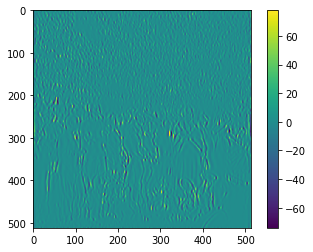

In [915]:
plt.figure()
plt.pcolormesh(np.real(complex_coarser_scale));
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

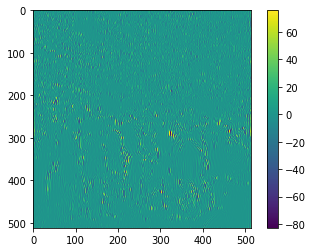

In [913]:
plt.figure()
plt.pcolormesh(np.real(complex_coarser_scale_phase_doubled));
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()


In [964]:
mag_this_scale = np.concatenate([np.expand_dims(np.abs(pyr.pyr_coeffs[(sc,ori)]) - np.mean(np.abs(pyr.pyr_coeffs[(sc,ori)])), axis=0) for ori in range(n_ori)], axis=0)

In [982]:
mag_this_scale.shape

(512, 512)

In [963]:
cousins[1].shape

(512, 512)

In [937]:
parents[0,0]

2.5897480079422834

In [985]:


# cousin_mean, ignore1, ignore2, ignore3 = get_weighted_pixel_features(np.expand_dims(cousins, axis=1), gauss)
# cousin_mean = torch_utils.get_value(cousin_mean)
# cousins_adj = (cousins - np.tile(np.expand_dims(cousin_mean, axis=2), [1,cousins.shape[1], cousins.shape[2]])) * 



In [978]:
np.tile(np.expand_dims(cousin_mean, axis=2), [1,cousins.shape[1], cousins.shape[2]]).shape

(4, 512, 512)

In [980]:
gauss.shape

(512, 512)

In [957]:
(parents - torch_utils.get_value(parent_mean[0,0])).shape

(512, 512)

In [968]:
np.expand_dims(cousins, axis=1).shape

(4, 1, 512, 512)

In [941]:
gauss.shape

(64, 64)

In [901]:
np.angle(complex_coarser_scale[0,0])*180/np.pi

48.473562568602624

In [900]:
np.angle(complex_coarser_scale_phase_doubled[0,0])*180/np.pi

96.94712513720525

In [1065]:
def double_phase(fmap):
    
    """
    Double the phase (i.e. angle) values of a complex array
    modified from https://github.com/LabForComputationalVision/textureSynth
    """     
    
    rtmp = np.real(fmap)
    itmp = np.imag(fmap)

    theta = np.arctan2(rtmp, itmp)
#     theta = np.arctan2(itmp, rtmp) # first get original phase (angle)
    rad = np.sqrt(rtmp**2 + itmp**2) # then get original magnitude

    # then put back together, using a*e^(ib)
    fmap_phase_doubled = rad * np.exp(2 * 1j*theta) 

    return fmap_phase_doubled

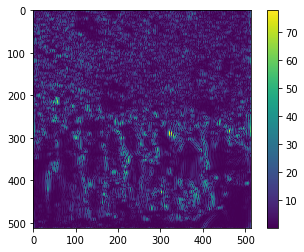

In [801]:
plt.figure()
plt.pcolormesh(np.abs(complex_coarser_scale_phase_doubled));
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [332]:

xvals, yvals = np.meshgrid(np.linspace(-1,1,npix), np.linspace(-1,1,npix));
rvals = np.sqrt(xvals**2 + yvals**2);
gauss = np.exp(-rvals/0.5);

spatial_weights = gauss
ind = [30,45,28,43]
ind = [ind[0]-1, ind[1], ind[2]-1, ind[3]]
acor = weighted_auto_corr_2d(np.expand_dims(np.expand_dims(ch, axis=0), axis=0), \
                                                spatial_weights, patch_bbox=ind, output_pix=7, \
                                               subtract_patch_mean=True, enforce_size=True, device=None)

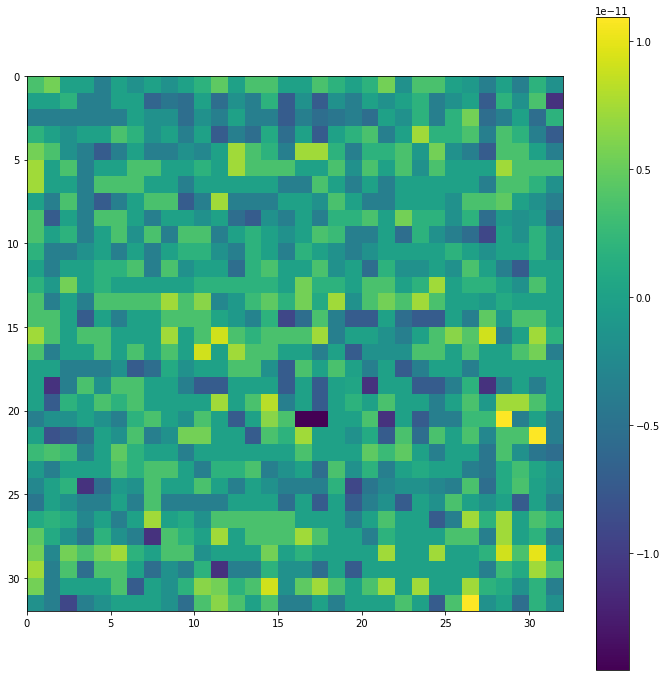

In [859]:
plt.figure(figsize=(12,12));
expanded = expand2(lowpass_recon, 2)
shrunk = shrink2(expanded, 2)
plt.pcolormesh(lowpass_recon - shrunk)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()


In [881]:
thing = np.array([1+2*1j, 3-5*1j])
print(thing)
print(np.conjugate(thing))

[1.+2.j 3.-5.j]
[1.-2.j 3.+5.j]


In [885]:
def expand(image_batch, factor):

    """
    Expand spatially an image in a factor f in X and in Y.
    Image may be complex.
    It fills in with zeros in the Fourier domain.
    image_batch_expanded = expand(image_batch, factor)
    
    
    Converted by MH from matlab function, from the library at:
    https://github.com/LabForComputationalVision/textureSynth
    
    % See also: shrink.m
    % JPM, May 95, Instituto de Optica, CSIC, Madrid.
    
    This version works for batches of images, OR single.
    Batches should be [batch_size x nchannels x height x width]
    If single image, should be [height x width]
    
    """

    if len(image_batch.shape)==2:
        image_batch = np.expand_dims(np.expand_dims(image_batch, axis=0), axis=0)
        single_image=True
    else:
        single_image=False
        
    batch_size, nchans, orig_height, orig_width =image_batch.shape
    new_height = int(orig_height*factor)
    new_width = int(orig_width*factor)
    
    freq_rep_exp = np.full((batch_size, nchans, new_height, new_width),0+0*1j)

    freq_rep = factor**2 * np.fft.fftshift(np.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
  
    y1 = int(new_height/2 + 2 - new_height/(2*factor))
    y2 = int(new_height/2 + new_height/(2*factor))

    x1 = int(new_width/2 + 2 - new_width/(2*factor))
    x2 = int(new_width/2 + new_width/(2*factor))

    freq_rep_exp[:,:,y1-1:y2, x1-1:x2] = freq_rep[:,:,1:int(new_height/factor), 1:int(new_width/factor)]
    freq_rep_exp[:,:,y1-2, x1-1:x2] = freq_rep[:,:,0, 1:int(new_width/factor)]/2
    freq_rep_exp[:,:,y2, x1-1:x2] = np.conjugate(freq_rep[:,:,0, int(new_width/factor):0:-1]/2)
    freq_rep_exp[:,:,y1-1:y2, x1-2] = freq_rep[:,:,1: int(new_height/factor), 0]/2
    freq_rep_exp[:,:,y1-1:y2, x2] = np.conjugate(freq_rep[:,:,int(new_height/factor):0:-1, 0]/2)

    esq=freq_rep[:,:,0,0]/4;
    freq_rep_exp[:,:,y1-2, x1-2] = esq
    freq_rep_exp[:,:,y1-2, x2] = esq
    freq_rep_exp[:,:,y2, x1-2] = esq
    freq_rep_exp[:,:,y2, x2] = esq

    image_batch_expanded = np.fft.ifft2(np.fft.ifftshift(freq_rep_exp, axes=(2,3)), axes=(2,3));
 
    if np.all(np.imag(image_batch)==0):
        image_batch_expanded = np.real(image_batch_expanded);
                    
    if single_image:
        image_batch_expanded = np.squeeze(np.squeeze(image_batch_expanded, axis=0), axis=0)
    
    return image_batch_expanded


In [884]:
def shrink(image_batch, factor):
    
    """
    Shrink spatially an image in a factor f in X and in Y.
    Image may be complex.
    image_batch_shrunk = shrink(image_batch, factor)
    
    Converted by MH from matlab function, from the library at:
    https://github.com/LabForComputationalVision/textureSynth
    
    % See also: expand.m
    % JPM, May 95, Instituto de Optica, CSIC, Madrid.
    
    This version works for batches of images, OR single.
    Batches should be [batch_size x nchannels x height x width]
    If single image, should be [height x width]
    
    """

    if len(image_batch.shape)==2:
        image_batch = np.expand_dims(np.expand_dims(image_batch, axis=0), axis=0)
        single_image=True
    else:
        single_image=False
        
    batch_size, nchans, orig_height, orig_width = image_batch.shape
    new_height = int(orig_height/factor)
    new_width = int(orig_width/factor)
    
    freq_rep_shr = np.full((batch_size, nchans, new_height, new_width),0+0*1j)

    freq_rep = 1/factor**2 * np.fft.fftshift(np.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
   
    y1 = int(orig_height/2 + 2 - orig_height/(2*factor))
    y2 = int(orig_height/2 + orig_height/(2*factor))

    x1 = int(orig_width/2 + 2 - orig_width/(2*factor))
    x2 = int(orig_width/2 + orig_width/(2*factor))

    freq_rep_shr[:,:,1:int(orig_height/factor), 1:int(orig_width/factor)] = freq_rep[:,:,y1-1:y2 ,x1-1:x2]
    freq_rep_shr[:,:,0,1:int(orig_width/factor)]=(freq_rep[:,:,y1-2, x1-1:x2]+freq_rep[:,:,y2, x1-1:x2])/2
    freq_rep_shr[:,:,1:int(orig_height/factor),0] = (freq_rep[:,:,y1-1:y2, x1-2] + freq_rep[:,:,y1-1:y2, x2])/2
    freq_rep_shr[:,:,0,0] = (freq_rep[:,:,y1-2,x1-1] + freq_rep[:,:,y1-2,x2] + freq_rep[:,:,y2, x1-1] + freq_rep[:,:,y2, x2+1])/4

    image_batch_shrunk = np.fft.ifft2(np.fft.ifftshift(freq_rep_shr, axes=(2,3)), axes=(2,3));
    
    if np.all(np.imag(image_batch)==0):
        image_batch_shrunk = np.real(image_batch_shrunk)
    
    if single_image:
        image_batch_shrunk = np.squeeze(np.squeeze(image_batch_shrunk, axis=0), axis=0)
    
    return image_batch_shrunk

In [856]:
def expand_old(image_batch, factor):

    """
    Expand spatially an image in a factor f in X and in Y.
    Image may be complex.
    It fills in with zeros in the Fourier domain.
    image_batch_expanded = expand(image_batch, factor)
    
    
    Converted by MH from matlab function, from the library at:
    https://github.com/LabForComputationalVision/textureSynth
    
    % See also: shrink.m
    % JPM, May 95, Instituto de Optica, CSIC, Madrid.
    
    This version works for batches of images, OR single.
    Batches should be [batch_size x nchannels x height x width]
    If single image, should be [height x width]
    
    """

    if len(image_batch.shape)==2:
        image_batch = np.expand_dims(np.expand_dims(image_batch, axis=0), axis=0)
        single_image=True
    else:
        single_image=False
        
    batch_size, nchans, orig_height, orig_width =image_batch.shape
    new_height = int(orig_height*factor)
    new_width = int(orig_width*factor)
    
    Te = np.full((batch_size, nchans, new_height, new_width),0+0*1j)
    
#     T_orig = factor**2 * scipy.fft.fftshift(scipy.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
#     T_orig = factor**2 * pyfftw.interfaces.numpy_fft.ifftshift(pyfftw.interfaces.numpy_fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
    T_orig = factor**2 * np.fft.fftshift(np.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
    T = copy.deepcopy(T_orig)
    
    y1 = int(new_height/2 + 2 - new_height/(2*factor) - 1)
    y2 = int(new_height/2 + new_height/(2*factor))
    y3 = int(new_height/factor)
    
    x1 = int(new_width/2 + 2 - new_width/(2*factor) - 1)
    x2 = int(new_width/2 + new_width/(2*factor))
    x3 = int(new_width/factor)
    
    Te[:,:,y1:y2, x1:x2] = copy.deepcopy(T[:,:,1:y3, 1:x3])
    Te[:,:,y1-1, x1:x2] = copy.deepcopy(T[:,:,0,1:x3])/2
    Te[:,:,y2,x1:x2] = np.conjugate(copy.deepcopy(T[:,:, 0, x3-1:0:-1])/2);        
    Te[:,:,y1:y2,x1-1]=copy.deepcopy(T[:,:,1:y3,1])/2;    
    Te[:,:,y1:y2,x2]=np.conjugate(copy.deepcopy(T[:,:, y3-1:0:-1, 0])/2);

    esq=T_orig[:,:,0,0]/4;
    Te[:,:,y1-1,x1-1]=esq;
    Te[:,:,y1-1,x2]=esq;
    Te[:,:,y2,x1-1]=esq;
    Te[:,:,y2,x2]=esq;

#     image_batch_expanded = scipy.fft.ifft2(scipy.fft.fftshift(Te, axes=(2,3)), axes=(2,3));
#     image_batch_expanded = pyfftw.interfaces.numpy_fft.ifft2(pyfftw.interfaces.numpy_fft.fftshift(Te, axes=(2,3)), axes=(2,3));
    image_batch_expanded = np.fft.ifft2(np.fft.ifftshift(Te, axes=(2,3)), axes=(2,3));
 
    if np.all(np.imag(image_batch)==0):
        image_batch_expanded = np.real(image_batch_expanded);
                    
    if single_image:
        image_batch_expanded = np.squeeze(np.squeeze(image_batch_expanded, axis=0), axis=0)
    
    return image_batch_expanded


(15896007+0j)
(-993330.2709407804+446867.43976213166j)
(-1314401.348873444+286334.97344710457j)
(-1236520.6795080812-888599.8919077796j)
(-1.7462298274040222e-10+0j)


(-1.7462298274040222e-10+0j)
(3.399236447876319e-11+4.865796654485166e-11j)
(6.821210263296962e-12-2.7284841053187847e-11j)
(1.9272166899306583e-10+1.913517609106174e-10j)
(15896007+0j)


(-1.7462298274040222e-10+0j)
(3.399236447876319e-11+4.865796654485166e-11j)
(6.821210263296962e-12-2.7284841053187847e-11j)
(1.9272166899306583e-10+1.913517609106174e-10j)
(15896007+0j)




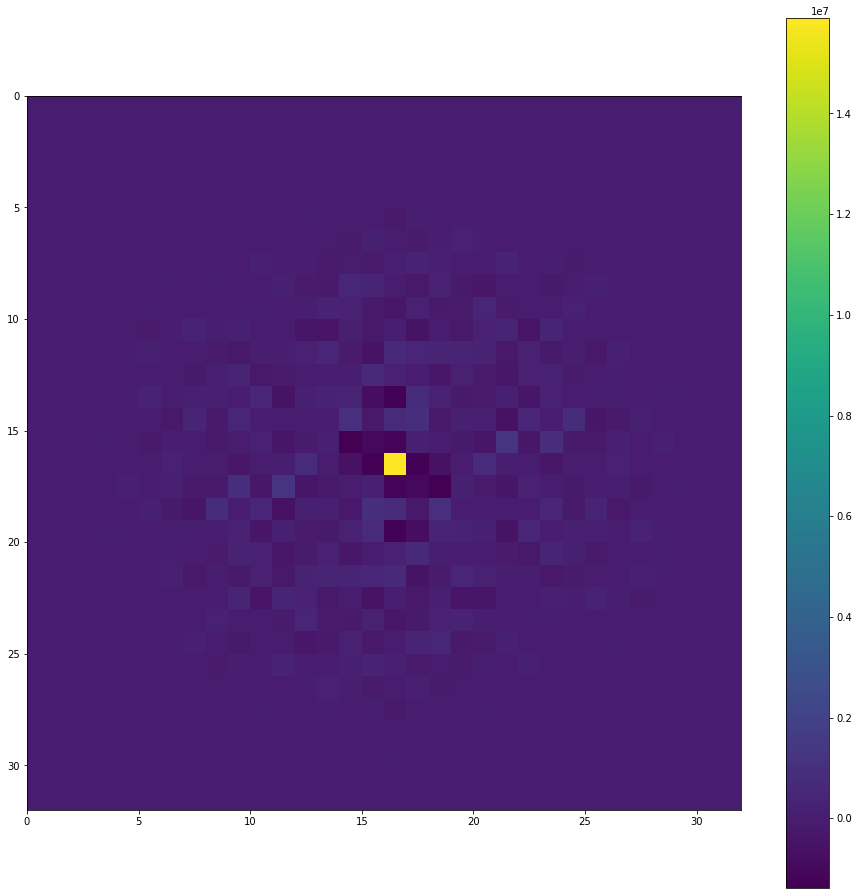

In [696]:
plt.figure(figsize=(16,16));
f1 = np.fft.fft2(image_batch, axes=(2,3))
f2 = np.fft.fftshift(f1)
f3 = np.fft.ifftshift(f1)
plt.pcolormesh(np.real(f2[0,0,:,:]))
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

print(f1[0,0,0,0])
print(f1[0,0,31,31])
print(f1[0,0,0,31])
print(f1[0,0,31,0])
print(f1[0,0,16,16])
print('\n')

print(f2[0,0,0,0])
print(f2[0,0,31,31])
print(f2[0,0,0,31])
print(f2[0,0,31,0])
print(f2[0,0,16,16])
print('\n')

print(f3[0,0,0,0])
print(f3[0,0,31,31])
print(f3[0,0,0,31])
print(f3[0,0,31,0])
print(f3[0,0,16,16])
print('\n')

In [700]:
f1[0,0,14,14]

(-9.185896487906575e-11+3.8198777474462986e-11j)

In [650]:
image_batch[0,0,9:20,9:20]

array([[15760.42555086, 12332.3037842 , 10504.07129037, 10384.79300471,
        11125.20772577, 12591.88218099, 13519.44609312, 11880.53001467,
         8491.05853588,  7587.7246807 , 11544.37354878],
       [13863.90418647, 10077.89451049,  8467.94587902,  8803.30431744,
         9731.57427912, 12064.53643396, 12946.80478652, 11253.09583849,
        11596.29800881, 12884.0368611 , 12662.72529689],
       [14645.81775148,  9803.59288089,  6238.32980526,  5269.01442076,
         5986.13347876,  9671.90245055, 11535.3323906 , 10131.23344355,
        12368.57832169, 15826.20255114, 14459.02893867],
       [14637.40459241,  9782.31030134,  7034.1072856 ,  7264.21320903,
         7232.17458895,  9141.46468732, 10086.37959571,  8751.02487512,
        10545.22365263, 15000.5983674 , 15403.54039978],
       [15153.43253318,  8191.40257697,  4387.33907629,  6129.3307048 ,
         6704.24067359,  7737.2960193 ,  7645.33336386,  6809.60090802,
         7507.97433633, 11371.9919102 , 14710.658334

In [663]:
import pyfftw

f1 = pyfftw.interfaces.numpy_fft.fft2(image_batch, axes=(3,2))

print(f1[0,0,16,16])
print(f1[0,0,0,0])
print(f1[0,0,31,31])

(-1.7462298274040222e-10+0j)
(15896007+0j)
(-993330.2709407804+446867.4397621318j)


In [664]:
f1[0,0,1,1]

(-993330.2709407804-446867.4397621318j)

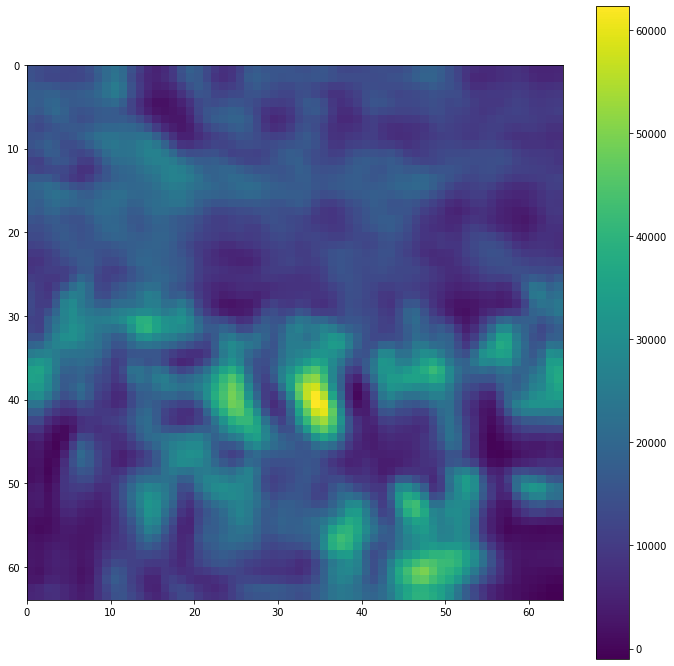

In [428]:
plt.figure(figsize=(12,12));
plt.pcolormesh(lowpass_new)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [399]:
im_resized = resize(image, [npix, npix])
pyr = pt.pyramids.SteerablePyramidFreq(im_resized, is_complex=False, height = 1, order = feature_extractor.n_ori-1)

bandpass_image1 = pyr.recon_pyr(levels=0, bands='all', twidth=1)

pyr_adj = copy.deepcopy(pyr)
pyr_adj.pyr_coeffs['residual_lowpass'] = np.zeros([smaller_size, smaller_size])
pyr_adj.pyr_coeffs['residual_highpass'] = np.zeros([npix, npix])

bandpass_image2 = pyr_adj.recon_pyr(levels=0, bands='all', twidth=1)

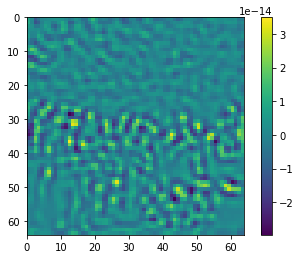

In [402]:
plt.figure();
plt.pcolormesh(bandpass_image)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [400]:
bandpass_image1[0,0]

1.900026145757245e-18

In [401]:
bandpass_image2[0,0]

1.900026145757245e-18

In [398]:
pyr_adj.pyr_size

{'residual_highpass': (64, 64),
 (0, 0): (64, 64),
 (0, 1): (64, 64),
 (0, 2): (64, 64),
 (0, 3): (64, 64),
 'residual_lowpass': (32, 32)}

In [319]:
if sc==0:
    smaller_size = pyr.pyr_size['residual_lowpass'][0]
else:
    smaller_size = pyr.pyr_size[(sc_reverse+1,0)][0]
[npix, smaller_size]

[256, 128]

In [423]:
import copy
pyr_fake = copy.deepcopy(pyr)
pyr_fake.pyr_coeffs = {}
pyr_fake.pyr_size = {}
for kk, key in enumerate(pyr.pyr_size.keys()):
    if key[0]==sc:
        pyr_fake.pyr_size[key] = pyr.pyr_size[key]
        pyr_fake.pyr_coeffs[key] = pyr.pyr_coeffs[key]
pyr_fake.pyr_size['residual_highpass'] = (npix, npix)
pyr_fake.pyr_size['residual_lowpass'] = (smaller_size, smaller_size)
pyr_fake.pyr_coeffs['residual_highpass'] = np.zeros((npix, npix))
pyr_fake.pyr_coeffs['residual_lowpass'] = np.zeros((smaller_size, smaller_size))

pyr_fake.pyr_size.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), 'residual_highpass', 'residual_lowpass'])

In [424]:
pyr_fake.pyr_size

{(0, 0): (512, 512),
 (0, 1): (512, 512),
 (0, 2): (512, 512),
 (0, 3): (512, 512),
 'residual_highpass': (64, 64),
 'residual_lowpass': (32, 32)}

In [360]:
recon_sfband = pyr_fake.recon_pyr()

ValueError: cannot reshape array of size 0 into shape (32,32)

In [361]:
pyr_fake.pyr_coeffs['residual_lowpass'].shape

(32, 32)

In [303]:
pyr.pyr_size

{'residual_highpass': (512, 512),
 (0, 0): (512, 512),
 (0, 1): (512, 512),
 (0, 2): (512, 512),
 (0, 3): (512, 512),
 (1, 0): (256, 256),
 (1, 1): (256, 256),
 (1, 2): (256, 256),
 (1, 3): (256, 256),
 (2, 0): (128, 128),
 (2, 1): (128, 128),
 (2, 2): (128, 128),
 (2, 3): (128, 128),
 (3, 0): (64, 64),
 (3, 1): (64, 64),
 (3, 2): (64, 64),
 (3, 3): (64, 64),
 'residual_lowpass': (32, 32)}

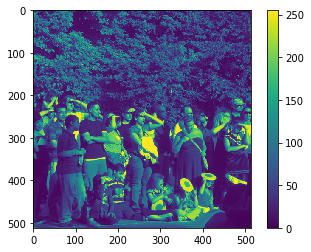

In [280]:
plt.figure()
plt.pcolormesh(full_image)
plt.axis('square')
plt.gca().invert_yaxis()
plt.colorbar()

In [46]:
feature_extractor_dummy.pyr_height

0

In [274]:
import torch.nn as nn

class steerable_pyramid_extractor(nn.Module):
    
    def __init__(self, pyr_height=4, n_ori=8):
        
        super(steerable_pyramid_extractor, self).__init__()       
        self.n_ori = n_ori
        self.pyr_height = pyr_height
        self.pyr = None
        
    def forward(self, image_batch, to_torch=False, device=None):
        
        batch_size = image_batch.shape[0]
        t  = time.time()
#         self.pyr = []
        for ii in range(batch_size):
            
            # Call the pyramid generation code here, get all features for this image.
            pyr = pt.pyramids.SteerablePyramidFreq(image_batch[ii,0,:,:], is_complex=True, height = self.pyr_height, order = self.n_ori-1)
            self.pyr = pyr
            
            if ii==0:  
                fmaps_complex = []
                fmaps_real = []
                sf_reverse  = self.pyr_height
                for sf in range(self.pyr_height):
                    sf_reverse -= 1
                    fmaps_complex.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],pyr.pyr_coeffs[sf_reverse,0].shape[1])))
                    fmaps_real.append(np.zeros((batch_size, self.n_ori,pyr.pyr_coeffs[sf_reverse,0].shape[0],pyr.pyr_coeffs[sf_reverse,0].shape[1])))
            
            fmaps_resid = []    
            fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_lowpass'].shape[0],pyr.pyr_coeffs['residual_lowpass'].shape[1])))
            fmaps_resid.append(np.zeros((batch_size,1,pyr.pyr_coeffs['residual_highpass'].shape[0],pyr.pyr_coeffs['residual_highpass'].shape[1])))

            # Feature maps will be listed from low SF to high SF. Each map stack is size [batch_size x orientations x height x width]
            sf_reverse  = self.pyr_height
            for sf in range(self.pyr_height):
                sf_reverse -= 1
                for oo in range(self.n_ori):     
                   
                    # take magnitude of complex number outputs
                    fmaps_complex[sf][ii,oo,:,:] = np.abs(pyr.pyr_coeffs[(sf_reverse,oo)])
                    
                    # also take real part of output
                    fmaps_real[sf][ii,oo,:,:] = np.real(pyr.pyr_coeffs[(sf_reverse,oo)])
            
            # Grab residuals too
            fmaps_resid[0][ii,0,:,:] = pyr.pyr_coeffs['residual_lowpass']
            fmaps_resid[1][ii,0,:,:] = pyr.pyr_coeffs['residual_highpass']
                       
        elapsed = time.time() - t
        print('time elapsed: %.5f s'%elapsed)

        if to_torch:            
            fmaps_complex = [torch_utils._to_torch(fm, device=device) for fm in fmaps_complex]
            fmaps_real = [torch_utils._to_torch(fm, device=device) for fm in fmaps_real]           
            fmaps_resid = [torch_utils._to_torch(fm, device=device) for fm in fmaps_resid]
        
        return fmaps_complex, fmaps_real, fmaps_resid
    
    def reconstruct(self):
        
        if self.pyr is None:
            raise ValueError('need to first do forward pass on a batch of images, before reconstructing them.')
      
        return self.pyr.recon_pyr()
        

In [396]:
def double_phase2(fmap):
    
    """
    Double the phase (i.e. angle) values of a complex array
    modified from https://github.com/LabForComputationalVision/textureSynth
    """     
    
    fmap_phase_doubled = np.abs(fmap) * np.exp(1j*np.angle(fmap)*2)

    return fmap_phase_doubled


In [815]:
def double_phase3(fmap):
   
    fmap_phase_doubled = fmap**2/np.abs(fmap)

    return fmap_phase_doubled

In [400]:
np.random.seed(344355)
thing = np.random.normal(0,1,[4,4]) + 1j*np.random.normal(0,1,[4,4])
print(thing[0,0])
print([np.real(thing[0,0]), np.imag(thing[0,0])])
print([np.abs(thing[0,0]), np.angle(thing[0,0])])

thing2 = double_phase(thing)
print('\n')
print(thing2[0,0])
print([np.real(thing2[0,0]), np.imag(thing2[0,0])])
print([np.abs(thing2[0,0]), np.angle(thing2[0,0])])

thing3 = double_phase3(thing)
print('\n')
print(thing3[0,0])
print([np.real(thing3[0,0]), np.imag(thing3[0,0])])
print([np.abs(thing3[0,0]), np.angle(thing3[0,0])])

(2.0919806594959898+0.7896347167889021j)
[2.0919806594959898, 0.7896347167889021]
[2.2360469730449686, 0.36092383602716605]


(1.67834582143705+1.4775186527852564j)
[1.67834582143705, 1.4775186527852564]
[2.236046973044968, 0.7218476720543321]


(1.6783458214370497+1.4775186527852566j)
[1.6783458214370497, 1.4775186527852566]
[2.236046973044968, 0.7218476720543322]


In [404]:
import numpy as np
import torch
import time
from collections import OrderedDict
import torch.nn as nn

from utils import numpy_utility, torch_utils
from model_src import fwrf_fit as fwrf_fit

class texture_feature_extractor(nn.Module):
    """
    Module to compute higher-order texture statistics of input images (similar to Portilla & Simoncelli style texture model), within specified area of space.
    Builds off lower-level feature maps for various orientation/spatial frequency bands, extracted using the modules specified in '_fmaps_fn_complex' and '_fmaps_fn_simple'
    Can specify different subsets of features to include (i.e. pixel-level stats, simple/complex cells, cross-correlations, auto-correlations)
    Inputs to the forward pass are images and pRF parameters of interest [x,y,sigma]
    """
    
    def __init__(self,_fmaps_fn_complex, _fmaps_fn_simple, sample_batch_size=100, feature_types_exclude=None, autocorr_output_pix=3, n_prf_sd_out=2, aperture=1.0, device=None):
        
        super(texture_feature_extractor, self).__init__()
        
        self.fmaps_fn_complex = _fmaps_fn_complex
        self.fmaps_fn_simple = _fmaps_fn_simple
        dtype = torch_utils.get_value(next(_fmaps_fn_complex.parameters())).dtype
        n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, np.zeros([2,1,2,2]).astype(dtype), device)  
        n_features_simple, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_simple, np.zeros([2,1,2,2]).astype(dtype), device)    
        self.n_sf = len(fmaps_rez)
        self.n_ori = int(n_features_complex/self.n_sf)
        self.n_phases = int(n_features_simple/self.n_sf/self.n_ori)

        self.sample_batch_size = sample_batch_size
        self.autocorr_output_pix = autocorr_output_pix
        self.n_prf_sd_out = n_prf_sd_out
        self.aperture = aperture
        self.device = device       
        
        self.update_feature_list(feature_types_exclude)
        
    def update_feature_list(self, feature_types_exclude):
        
        feature_types_all = ['wmean','wvar','wskew','wkurt', 'complex_feature_means', 'simple_feature_means',\
                         'complex_feature_autocorrs','simple_feature_autocorrs',\
                         'complex_within_scale_crosscorrs','simple_within_scale_crosscorrs',\
                         'complex_across_scale_crosscorrs','simple_across_scale_crosscorrs']
       
        ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, self.n_ori)] for oo1 in range(self.n_ori) if oo1<self.n_ori-1])
        n_ori_pairs = np.shape(ori_pairs)[0]
        feature_type_dims = [1,1,1,1,self.n_ori*self.n_sf, self.n_ori*self.n_sf*self.n_phases, \
                              self.n_ori*self.n_sf*self.autocorr_output_pix**2, self.n_ori*self.n_sf*self.n_phases*self.autocorr_output_pix**2, \
                              self.n_sf*n_ori_pairs, self.n_sf*n_ori_pairs*self.n_phases, (self.n_sf-1)*self.n_ori**2, (self.n_sf-1)*self.n_ori**2*self.n_phases]
        
        # decide which features to ignore, or use all features
        self.feature_types_exclude = feature_types_exclude

        # a few shorthands for ignoring sets of features at a time
        if 'crosscorrs' in feature_types_exclude:
            feature_types_exclude.extend(['complex_within_scale_crosscorrs','simple_within_scale_crosscorrs','complex_across_scale_crosscorrs','simple_across_scale_crosscorrs'])
        if 'autocorrs' in feature_types_exclude:
            feature_types_exclude.extend(['complex_feature_autocorrs','simple_feature_autocorrs'])
        if 'pixel' in feature_types_exclude:
            feature_types_exclude.extend(['wmean','wvar','wskew','wkurt'])

        self.feature_types_include  = [ff for ff in feature_types_all if not ff in feature_types_exclude]
        if len(self.feature_types_include)==0:
            raise ValueError('you have specified too many features to exclude, and now you have no features left! aborting.')
            
        feature_dims_include = [feature_type_dims[fi] for fi in range(len(feature_type_dims)) if not feature_types_all[fi] in feature_types_exclude]
        # how many features will be needed, in total?
        self.n_features_total = np.sum(feature_dims_include)
        
        # numbers that define which feature types are in which column
        self.feature_column_labels = np.squeeze(np.concatenate([fi*np.ones([1,feature_dims_include[fi]]) for fi in range(len(feature_dims_include))], axis=1).astype('int'))
        assert(np.size(self.feature_column_labels)==self.n_features_total)

    
    def forward(self, images, prf_params):
        
        if isinstance(prf_params, torch.Tensor):
            prf_params = torch_utils.get_value(prf_params)
        assert(np.size(prf_params)==3)
        prf_params = np.squeeze(prf_params)
        if isinstance(images, torch.Tensor):
            images = torch_utils.get_value(images)

        print('Computing pixel-level statistics...')    
        t=time.time()
        x,y,sigma = prf_params
        n_pix=np.shape(images)[2]
        g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=self.aperture, dtype=np.float32)
        spatial_weights = g[2][0]
        wmean, wvar, wskew, wkurt = get_weighted_pixel_features(images, spatial_weights, device=self.device)
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

        print('Computing complex cell features...')
        t = time.time()
        complex_feature_means = fwrf_fit.get_features_in_prf(prf_params, self.fmaps_fn_complex , images=images, sample_batch_size=self.sample_batch_size, aperture=self.aperture, device=self.device, to_numpy=False)
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

        print('Computing simple cell features...')
        t = time.time()
        simple_feature_means = fwrf_fit.get_features_in_prf(prf_params,  self.fmaps_fn_simple, images=images, sample_batch_size=self.sample_batch_size, aperture=self.aperture,  device=self.device, to_numpy=False)
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

        # To save time, decide now whether any autocorrelation or cross-correlation features are desired. If not, will skip a bunch of the slower computations.     
        self.include_crosscorrs = np.any(['crosscorr' in ff for ff in self.feature_types_include])
        self.include_autocorrs = np.any(['autocorr' in ff for ff in self.feature_types_include])
        
        if self.include_autocorrs and self.include_crosscorrs:
            print('Computing higher order correlations...')
        elif self.include_crosscorrs:
            print('Computing higher order correlations (SKIPPING AUTOCORRELATIONS)...')
        elif self.include_autocorrs:
            print('Computing higher order correlations (SKIPPING CROSSCORRELATIONS)...')
        else:
            print('SKIPPING HIGHER-ORDER CORRELATIONS...')    
        t = time.time()
        complex_feature_autocorrs, simple_feature_autocorrs, \
        complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, \
        complex_across_scale_crosscorrs, simple_across_scale_crosscorrs = get_higher_order_features(self.fmaps_fn_complex, self.fmaps_fn_simple, images, prf_params=prf_params, 
                                                                                                    sample_batch_size=self.sample_batch_size, include_autocorrs=self.include_autocorrs, include_crosscorrs=self.include_crosscorrs, 
                                                                                                    autocorr_output_pix=self.autocorr_output_pix, n_prf_sd_out=self.n_prf_sd_out, 
                                                                                                    aperture=self.aperture,  device=self.device)
        elapsed =  time.time() - t
        print('time elapsed = %.5f'%elapsed)

        all_feat = OrderedDict({'wmean': wmean, 'wvar':wvar, 'wskew':wskew, 'wkurt':wkurt, 'complex_feature_means':complex_feature_means, 'simple_feature_means':simple_feature_means, 
                    'complex_feature_autocorrs': complex_feature_autocorrs, 'simple_feature_autocorrs': simple_feature_autocorrs, 
                    'complex_within_scale_crosscorrs': complex_within_scale_crosscorrs, 'simple_within_scale_crosscorrs':simple_within_scale_crosscorrs,
                    'complex_across_scale_crosscorrs': complex_across_scale_crosscorrs, 'simple_across_scale_crosscorrs':simple_across_scale_crosscorrs})

        feature_names_full = list(all_feat.keys())
        feature_names = [fname for fname in feature_names_full if fname in self.feature_types_include]
        assert(feature_names==self.feature_types_include) # double check here that the order is correct
        
        for ff, feature_name in enumerate(feature_names):   
            assert(all_feat[feature_name] is not None)
            if ff==0:
                all_feat_concat = all_feat[feature_name]
            else:               
                all_feat_concat = torch.cat((all_feat_concat, all_feat[feature_name]), axis=1)

        assert(all_feat_concat.shape[1]==self.n_features_total)
        print('Final size of features concatenated is [%d x %d]'%(all_feat_concat.shape[0], all_feat_concat.shape[1]))
        print('Feature types included are:')
        print(feature_names)

        if torch.any(torch.isnan(all_feat_concat)):
            print('\nWARNING THERE ARE NANS IN FEATURES MATRIX\n')

        return all_feat_concat, [self.feature_column_labels, feature_names]
    

In [992]:

def get_higher_order_features(_fmaps_fn_complex, _fmaps_fn_simple, images, prf_params, sample_batch_size=20, include_autocorrs=True, include_crosscorrs=True, autocorr_output_pix=7, n_prf_sd_out=2, aperture=1.0, device=None):

    """
    Compute all higher-order features (cross-spatial and cross-feature correlations) for a batch of images.
    Input the functions that define first level feature maps (simple and complex cells), and prf parameters.
    Returns arrays of each higher order feature.    
    """
    
    if device is None:
        device = torch.device('cpu:0')    
        
    n_trials = np.shape(images)[0]
    
    assert(np.mod(autocorr_output_pix,2)==1) # must be odd!

    n_features_simple, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_simple, images[0:sample_batch_size], device)
    n_features_complex, fmaps_rez = fwrf_fit.get_fmaps_sizes(_fmaps_fn_complex, images[0:sample_batch_size], device)
    
    n_sf = len(fmaps_rez)
    n_ori = int(n_features_complex/n_sf)
    n_phases = 2
    
    # all pairs of different orientation channels.
    ori_pairs = np.vstack([[[oo1, oo2] for oo2 in np.arange(oo1+1, n_ori)] for oo1 in range(n_ori) if oo1<n_ori-1])
    n_ori_pairs = np.shape(ori_pairs)[0]

    if include_autocorrs:
        complex_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, autocorr_output_pix**2], device=device)
        simple_feature_autocorrs = torch.zeros([n_trials, n_sf, n_ori, n_phases, autocorr_output_pix**2], device=device)
    else:
        complex_feature_autocorrs = None
        simple_feature_autocorrs = None
    
    if include_crosscorrs:
        complex_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_ori_pairs], device=device)
        simple_within_scale_crosscorrs = torch.zeros([n_trials, n_sf, n_phases, n_ori_pairs], device=device)
        complex_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_ori, n_ori], device=device)
        simple_across_scale_crosscorrs = torch.zeros([n_trials, n_sf-1, n_phases, n_ori, n_ori], device=device) # only done for pairs of neighboring SF.
    else:
        complex_within_scale_crosscorrs = None
        simple_within_scale_crosscorrs = None
        complex_across_scale_crosscorrs = None
        simple_across_scale_crosscorrs = None
        
    if include_autocorrs or include_crosscorrs:
        
        x,y,sigma = prf_params

        bb=-1
        for batch_inds, batch_size_actual in numpy_utility.iterate_range(0, n_trials, sample_batch_size):
            bb=bb+1

            fmaps_complex = _fmaps_fn_complex(torch_utils._to_torch(images[batch_inds],device=device))   
            fmaps_simple =  _fmaps_fn_simple(torch_utils._to_torch(images[batch_inds],device=device))

            # First looping over frequency (scales)
            for ff in range(n_sf):

                # Scale specific things - get the prf at this resolution of interest
                n_pix = fmaps_rez[ff]
                g = numpy_utility.make_gaussian_mass_stack([x], [y], [sigma], n_pix=n_pix, size=aperture, dtype=np.float32)
                spatial_weights = g[2][0]

                patch_bbox_rect = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=False)
                # for autocorrelation, forcing the input region to be square
                patch_bbox_square = get_bbox_from_prf(prf_params, spatial_weights.shape, n_prf_sd_out, force_square=True)

                # Loop over orientation channels
                xx=-1
                for oo1 in range(n_ori):       


                    # Simple cell responses - loop over two phases per orient.
                    for pp in range(n_phases):
                        filter_ind = n_phases*oo1+pp  # orients and phases are both listed in the same dimension of filters matrix               
                        simple1 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                        # Simple cell autocorrelations.
                        if include_autocorrs:
                            auto_corr = weighted_auto_corr_2d(simple1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)
                            simple_feature_autocorrs[batch_inds,ff,oo1,pp,:] = torch.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                    # Complex cell responses
                    complex1 = fmaps_complex[ff][:,oo1,:,:].view([batch_size_actual,1,n_pix,n_pix])

                    # Complex cell autocorrelation (correlation w spatially shifted versions of itself)
                    if include_autocorrs:
                        auto_corr = weighted_auto_corr_2d(complex1, spatial_weights, patch_bbox=patch_bbox_square, output_pix = autocorr_output_pix, subtract_patch_mean = True, enforce_size=True, device=device)       
                        complex_feature_autocorrs[batch_inds,ff,oo1,:] = torch.reshape(auto_corr, [batch_size_actual, autocorr_output_pix**2])

                    if include_crosscorrs:
                        # Within-scale correlations - compare resp at orient==oo1 to responses at all other orientations, same scale.
                        for oo2 in np.arange(oo1+1, n_ori):            
                            xx = xx+1 
                            assert(oo1==ori_pairs[xx,0] and oo2==ori_pairs[xx,1])

                            complex2 = fmaps_complex[ff][:,oo2,:,:].view([batch_size_actual,1,n_pix,n_pix])      

                            # Complex cell within-scale cross correlations
                            cross_corr = weighted_cross_corr_2d(complex1, complex2, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)

                            complex_within_scale_crosscorrs[batch_inds,ff,xx] = torch.squeeze(cross_corr);

                            # Simple cell within-scale cross correlations
                            for pp in range(n_phases):
                                filter_ind = n_phases*oo2+pp
                                simple2 = fmaps_simple[ff][:,filter_ind,:,:].view([batch_size_actual,1,n_pix,n_pix])

                                cross_corr = weighted_cross_corr_2d(simple1, simple2, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                                simple_within_scale_crosscorrs[batch_inds,ff,pp,xx] = torch.squeeze(cross_corr);

                        # Cross-scale correlations - for these we care about same ori to same ori, so looping over all ori.
                        # Only for neighboring scales, so the first level doesn't get one
                        if ff>0:

                            for oo2 in range(n_ori):

                                # Complex cell response for neighboring scale
                                complex2_neighborscale = fmaps_complex[ff-1][:,oo2,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                                # Resize so that it can be compared w current scale
                                complex2_neighborscale = torch.nn.functional.interpolate(complex2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                                cross_corr = weighted_cross_corr_2d(complex1, complex2_neighborscale, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                                complex_across_scale_crosscorrs[batch_inds,ff-1, oo1, oo2] = torch.squeeze(cross_corr)

                                for pp in range(n_phases):
                                    filter_ind = n_phases*oo2+pp
                                    # Simple cell response for neighboring scale
                                    simple2_neighborscale = fmaps_simple[ff-1][:,filter_ind,:,:].view([batch_size_actual,1,fmaps_rez[ff-1], -1])
                                    simple2_neighborscale = torch.nn.functional.interpolate(simple2_neighborscale, [n_pix, n_pix], mode='bilinear', align_corners=True)

                                    cross_corr = weighted_cross_corr_2d(simple1, simple2_neighborscale, spatial_weights, patch_bbox=patch_bbox_rect, subtract_patch_mean = True, device=device)
                                    simple_across_scale_crosscorrs[batch_inds,ff-1, pp, oo1, oo2] = torch.squeeze(cross_corr)

    if include_crosscorrs:
        simple_within_scale_crosscorrs = torch.reshape(simple_within_scale_crosscorrs, [n_trials, -1])
        simple_across_scale_crosscorrs = torch.reshape(simple_across_scale_crosscorrs, [n_trials, -1])
        complex_within_scale_crosscorrs = torch.reshape(complex_within_scale_crosscorrs, [n_trials, -1])
        complex_across_scale_crosscorrs = torch.reshape(complex_across_scale_crosscorrs, [n_trials, -1])
    if include_autocorrs:
        simple_feature_autocorrs = torch.reshape(simple_feature_autocorrs, [n_trials, -1])
        complex_feature_autocorrs = torch.reshape(complex_feature_autocorrs, [n_trials, -1])

    return complex_feature_autocorrs, simple_feature_autocorrs, complex_within_scale_crosscorrs, simple_within_scale_crosscorrs, complex_across_scale_crosscorrs, simple_across_scale_crosscorrs



def get_bbox_from_prf(prf_params, image_size, n_prf_sd_out=2, verbose=False, force_square=False):
    """
    For a given pRF center and size, calculate the square bounding box that captures a specified number of SDs from the center (default=2 SD)
    Returns [xmin, xmax, ymin, ymax]
    """
    x,y,sigma = prf_params
    n_pix = image_size[0]
    assert(image_size[1]==n_pix)
    assert(sigma>0 and n_prf_sd_out>0)
    
    # decide on the window to use for correlations, based on prf parameters. Patch goes # SD from the center (2 by default).
    # note this can't be < 1, even for the smallest choice of parameters (since rounding up). this way it won't be too small.
    pix_from_center = int(np.ceil(sigma*n_prf_sd_out*n_pix))

    # center goes [row ind, col ind]
    center = np.array((n_pix/2  - y*n_pix, x*n_pix + n_pix/2)) # note that the x/y dims get swapped here because of how pRF parameters are defined.

    # now defining the extent of the bbox. want to err on the side of making it too big, so taking floor/ceiling...
    xmin = int(np.floor(center[0]-pix_from_center))
    xmax = int(np.ceil(center[0]+pix_from_center))
    ymin = int(np.floor(center[1]-pix_from_center))
    ymax = int(np.ceil(center[1]+pix_from_center))

    # cropping it to within the image bounds. Can end up being a rectangle rather than square.
    [xmin, xmax, ymin, ymax] = np.maximum(np.minimum([xmin, xmax, ymin, ymax], n_pix), 0)

    # decide if we want square or are ok with a rectangle
    if force_square:
        minside = np.min([xmax-xmin, ymax-ymin])
        maxside = np.max([xmax-xmin, ymax-ymin])
        if minside!=maxside:

            if verbose:
                print('trimming bbox to make it square')
                print('original bbox was:')
                print([xmin, xmax, ymin, ymax])

            n2trim = [int(np.floor((maxside-minside)/2)), int(np.ceil((maxside-minside)/2))]

            if np.argmin([xmax-xmin, ymax-ymin])==0:
                ymin = ymin+n2trim[0]
                ymax = ymax-n2trim[1]
            else:
                xmin = xmin+n2trim[0]
                xmax = xmax-n2trim[1]

        assert((xmax-xmin)==(ymax-ymin))

    if verbose:
        print('final bbox will be:')
        print([xmin, xmax, ymin, ymax])
        
    # checking to see if the patch has become just one pixel. this can happen due to the cropping.
    # if this happens, cross-correlations will give zero.
    if ((xmax-xmin)<2 or (ymax-ymin)<2):
        print('Warning: your patch only has one pixel (for n_pix: %d and prf params: [%.2f, %.2f, %.2f])\n'%(n_pix,x,y,sigma))      
        
    return [xmin, xmax, ymin, ymax]

def weighted_auto_corr_2d(images, spatial_weights, patch_bbox=None, output_pix=None, subtract_patch_mean=False, enforce_size=False, device=None):

    """
    Compute autocorrelation of a batch of images, weighting the pixels based on the values in spatial_weights (could be for instance a pRF definition for a voxel).
    Can optionally specify a square patch of the image to compute over, based on "patch_bbox" params. Otherwise use whole image.
    Using fft method to compute, should be fast.
    Input parameters:
        patch_bbox: (optional) bounding box of the patch to use for this calculation. [xmin xmax ymin ymax], see get_bbox_from_prf
        output_pix: the size of the autocorrelation matrix output by this function. If this is an even number, the output size is this value +1. Achieved by cropping out the center of the final autocorrelation 
            matrix  (note that the full image patch is still used in computing the autocorrelation, but just the center values are returned).
            If None, then returns the full autocorrelation matrix (same size as image patch.)
        subtract_patch_mean: subtract weighted mean of image before computing autocorr?
        enforce_size: if image patch is smaller than desired output, should we pad w zeros so that it has to be same size?
    Returns:
        A matrix describing the correlation of the image and various spatially shifted versions of it.
    """
    
    
    if device is None:
        device = torch.device('cpu:0')        
    if isinstance(images, np.ndarray):
        images = torch_utils._to_torch(images, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)
            
    if len(np.shape(images))==2:
        # pretend the batch and channel dims exist, for 2D input only (3D won't work)
        single_image=True
        images = images.view([1,1,images.shape[0],-1])
    else:
        single_image=False
        
    # have to be same size
    assert(images.shape[2]==spatial_weights.shape[0] and images.shape[3]==spatial_weights.shape[1])
    # images is [batch_size x n_channels x nPix x nPix]
    batch_size = images.shape[0]
    n_channels = images.shape[1]    
   
    sum_weights_full = torch.sum(spatial_weights)

    if patch_bbox is not None:    
        [xmin, xmax, ymin, ymax] = patch_bbox
        # first crop out the region of the image that's currently of interest
        images = images[:,:,xmin:xmax, ymin:ymax]
        # crop same region from spatial weights matrix
        spatial_weights = spatial_weights[xmin:xmax, ymin:ymax]

    sum_weights = torch.sum(spatial_weights)

    # make sure these sum to 1
#     if not torch.sum(spatial_weights)==0.0:
#         spatial_weights = spatial_weights/torch.sum(spatial_weights)   
   
    spatial_weights = spatial_weights.view([1,1,spatial_weights.shape[0],-1]).expand([batch_size,n_channels,-1,-1]) # [batch_size x n_channels x nPix x nPix]    
    
    # compute autocorrelation of this image patch
    if subtract_patch_mean:

        wmean = torch.sum(torch.sum(images * spatial_weights/sum_weights, dim=3), dim=2) # size is [batch_size x 1]
#         wmean = torch.sum(torch.sum(images * spatial_weights, dim=3), dim=2) # size is [batch_size x 1]
        wmean = wmean.view([batch_size,-1,1,1]).expand([-1,-1,images.shape[2],images.shape[3]]) # [batch_size x n_channels x nPix x nPix]
        
        weighted_images = (images - wmean) * torch.sqrt(spatial_weights/sum_weights_full) # square root of the weights here because they will get squared again in next operation
#         weighted_images = (images - wmean) * torch.sqrt(spatial_weights) # square root of the weights here because they will get squared again in next operation
        
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);
    else:
        weighted_images = images * torch.sqrt(spatial_weights_full/sum_weights_full)
#         weighted_images = images * torch.sqrt(spatial_weights)
        auto_corr = torch.fft.fftshift(torch.real(torch.fft.ifft2(torch.abs(torch.fft.fft2(weighted_images, dim=[2,3]))**2, dim=[2,3])), dim=[2,3]);

    if output_pix is not None:

        # crop out just the center region
        new_center = int(np.floor(auto_corr.shape[2]/2))
        n_pix_out = np.min([int(np.floor(output_pix/2)), np.min([new_center, auto_corr.shape[2]-new_center])])
        auto_corr = auto_corr[:,:,new_center-n_pix_out:new_center+n_pix_out+1, new_center-n_pix_out:new_center+n_pix_out+1]        
    
    if enforce_size and not (np.shape(auto_corr)[2]==output_pix or np.shape(auto_corr)[2]==output_pix+1):
        
        # just pad w zeros if want same size.
        pix_diff = output_pix - np.shape(auto_corr)[2]   
        auto_corr = torch.nn.functional.pad(auto_corr, [int(np.floor(pix_diff/2)), int(np.ceil(pix_diff/2)), int(np.floor(pix_diff/2)), int(np.ceil(pix_diff/2))], mode='constant', value=0)
        assert(np.shape(auto_corr)[2]==output_pix and np.shape(auto_corr)[3]==output_pix)

    if single_image:
        auto_corr = torch.squeeze(auto_corr)
        
    return auto_corr




def get_weighted_pixel_features(image_batch, spatial_weights, device=None):
    """
    Compute mean, variance, skewness, kurtosis of luminance values for each of a batch of images.
    Input size is [batch_size x n_channels x npix x npix]
    Spatial weights describes a weighting function, [npix x npix]
    Returns [batch_size x n_channels] size array for each property.
    """
    
    if isinstance(image_batch, np.ndarray):
        image_batch = torch_utils._to_torch(image_batch, device)
    if isinstance(spatial_weights, np.ndarray):
        spatial_weights = torch_utils._to_torch(spatial_weights, device)
     
    assert(image_batch.shape[2]==spatial_weights.shape[0] and image_batch.shape[3]==spatial_weights.shape[1])
    assert(image_batch.shape[1]==1)
    
    batch_size = image_batch.shape[0]
    n_channels = image_batch.shape[1]
    n_pix = image_batch.shape[2]

    image_batch = image_batch.view([batch_size, n_channels, n_pix**2])
    spatial_weights = spatial_weights/torch.sum(spatial_weights)
    spatial_weights = spatial_weights.view([1,1,n_pix**2]).expand([batch_size,n_channels,-1]) # [batch_size x n_channels x nPix x nPix]    
   
    ims_weighted = image_batch * spatial_weights
   
    wmean = torch.sum(ims_weighted, axis=2).view([batch_size,-1,1])

    wvar = torch.sum(spatial_weights * (image_batch - wmean.expand([-1,-1,n_pix**2]))**2, axis=2).view([batch_size,-1,1])
    
    wskew = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**3 / (wvar**(3/2)), axis=2).view([batch_size,-1,1])
    
    wkurt = torch.sum(spatial_weights *(image_batch - wmean.expand([-1,-1,n_pix**2]))**4 / (wvar**(2)), axis=2).view([batch_size,-1,1])
    
    # correct for nans/inf values which happen when variance is very small (denominator)
    wskew[torch.isnan(wskew)] = 0.0
    wkurt[torch.isnan(wkurt)] = 0.0
    wskew[torch.isinf(wskew)] = 0.0
    wkurt[torch.isinf(wkurt)] = 0.0
    
    return torch.squeeze(wmean, dim=2), torch.squeeze(wvar, dim=2), torch.squeeze(wskew, dim=2), torch.squeeze(wkurt, dim=2)


In [855]:
def shrink_old(image_batch, factor):
    
    """
    Shrink spatially an image in a factor f in X and in Y.
    Image may be complex.
    image_batch_shrunk = shrink(image_batch, factor)
    
    Converted by MH from matlab function, from the library at:
    https://github.com/LabForComputationalVision/textureSynth
    
    % See also: expand.m
    % JPM, May 95, Instituto de Optica, CSIC, Madrid.
    
    This version works for batches of images, OR single.
    Batches should be [batch_size x nchannels x height x width]
    If single image, should be [height x width]
    
    """

    if len(image_batch.shape)==2:
        image_batch = np.expand_dims(np.expand_dims(image_batch, axis=0), axis=0)
        single_image=True
    else:
        single_image=False
        
    batch_size, nchans, orig_height, orig_width = image_batch.shape
    new_height = int(orig_height/factor)
    new_width = int(orig_width/factor)
    
    Ts = np.full((batch_size, nchans, new_height, new_width),0+0*1j)
    
#     T_orig = 1/factor**2 * scipy.fft.fftshift(scipy.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
#     T_orig = 1/factor**2 * pyfftw.interfaces.numpy_fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
    T_orig = 1/factor**2 * np.fft.fftshift(np.fft.fft2(image_batch, axes=(2,3)), axes=(2,3))
    T = copy.deepcopy(T_orig)
    
    y1 = int(orig_height/2 + 2 - orig_height/(2*factor) - 1)
    y2 = int(orig_height/2 + orig_height/(2*factor))
    y3 = int(orig_height/factor)
    
    x1 = int(orig_width/2 + 2 - orig_width/(2*factor) - 1)
    x2 = int(orig_width/2 + orig_width/(2*factor))
    x3 = int(orig_width/factor)
    
    Ts[:,:,1:y3, 1:x3] = copy.deepcopy(T[:,:,y1:y2,x1:x2]);
    Ts[:,:,0, 1:x3] = (copy.deepcopy(T[:,:,y1-1,x1:x2]) + copy.deepcopy(T[:,:,y2,x1:x2])) / 2;
    Ts[:,:,1:y3,0] = (copy.deepcopy(T[:,:,y1:y2,x1-1]) + copy.deepcopy(T[:,:,y1:y2,x2])) / 2;
    Ts[:,:,0,0] = (copy.deepcopy(T[:,:,y1-1,x1-1]) + copy.deepcopy(T[:,:,y1-1,x2]) +\
                   copy.deepcopy(T[:,:,y2,x1-1]) + copy.deepcopy(T[:,:,y2,x2])) / 4;
    
#     image_batch_shrunk = scipy.fft.ifft2(scipy.fft.ifftshift(Ts, axes=(2,3)), axes=(2,3));
#     image_batch_shrunk = pyfftw.interfaces.numpy_fft.ifft2(pyfftw.interfaces.numpy_fft.ifftshift(Ts, axes=(2,3)), axes=(2,3));
    image_batch_shrunk = np.fft.ifft2(np.fft.ifftshift(Ts, axes=(2,3)), axes=(2,3));
    
    if np.all(np.imag(image_batch)==0):
        image_batch_shrunk = np.real(image_batch_shrunk)
    
    if single_image:
        image_batch_shrunk = np.squeeze(np.squeeze(image_batch_shrunk, axis=0), axis=0)
    
    return image_batch_shrunk

In [853]:
def shrink2(t, f):
	my,mx = t.shape
	T=np.fft.fftshift(np.fft.fft2(t))/f**2
	Ts=np.zeros((int(my/f), int(mx/f)), dtype=complex)
	y1=int(my/2 + 2 - my/(2*f))
	y2=int(my/2 + my/(2*f))
	x1=int(mx/2 + 2 - mx/(2*f))
	x2=int(mx/2 + mx/(2*f))

	Ts[1:int(my/f), 1:int(mx/f)] = T[y1-1:y2 ,x1-1:x2]
	Ts[0,1:int(mx/f)]=(T[y1-2, x1-1:x2]+T[y2, x1-1:x2])/2
	Ts[1:int(my/f),0] = (T[y1-1:y2, x1-2] + T[y1-1:y2, x2])/2
	Ts[0,0] = (T[y1-2,x1-1] + T[y1-2,x2] + T[y2, x1-1] + T[y2, x2+1])/4
	Ts=np.fft.fftshift(Ts)
	ts=np.fft.ifft2(Ts)
	ts = ts.real
#	ts = np.abs(ts)

	return ts

In [854]:
def expand2(t ,f, p=0):
	my,mx = t.shape
	T = np.zeros((my, mx), dtype=complex)
	my = f*my
	mx = f*mx
	Te = np.zeros((my, mx), dtype=complex)

	T = f**2 * np.fft.fftshift(np.fft.fft2(t))
	y1 = my/2 + 2 - my/(2*f)
	y2 = my/2 + my/(2*f)
	x1 = mx/2 + 2 - mx/(2*f)
	x2 = mx/2 + mx/(2*f)
	y1 = int(y1)
	y2 = int(y2)
	x1 = int(x1)
	x2 = int(x2)
    
	Te[y1-1:y2, x1-1:x2] = T[1:int(my/f), 1:int(mx/f)]
	Te[y1-2, x1-1:x2] = T[0, 1:int(mx/f)]/2
	Te[y2, x1-1:x2] = T[0, int(mx/f):0:-1]/2
	Te[y1-1:y2, x1-2] = T[1: int(my/f), 0]/2
	Te[y1-1:y2, x2] = T[int(my/f):0:-1, 0]/2

	esq = T[0,0] / 4
	Te[y1-2, x1-2] = esq
	Te[y1-2, x2] = esq
	Te[y2, x1-2] = esq
	Te[y2, x2] = esq

	Te = np.fft.fftshift(Te)
	te = np.fft.ifft2(Te)
	te = te.real

	return te
